Mean Absolute Error (MAE): 43.81
Mean Squared Error (MSE): 4498.22
R² Score: -6713.6685
Mean Absolute Error (MAE): 21.26
Mean Squared Error (MSE): 717.57
R² Score: -11938.7677
Mean Absolute Error (MAE): 0.59
Mean Squared Error (MSE): 0.66
R² Score: -13.3141
Mean Absolute Error (MAE): 3.59
Mean Squared Error (MSE): 18.01
R² Score: -768.4113
Mean Absolute Error (MAE): 0.22
Mean Squared Error (MSE): 0.07
R² Score: -4.3338
          Date  Actual Confirmed  Predicted Confirmed
227 2020-09-05        26887771.0         3.469439e+07
228 2020-09-06        27109897.0         3.282493e+07
229 2020-09-07        27343696.0         2.859260e+07
230 2020-09-08        27585104.0         5.385178e+07
231 2020-09-09        27869487.0         3.448685e+07


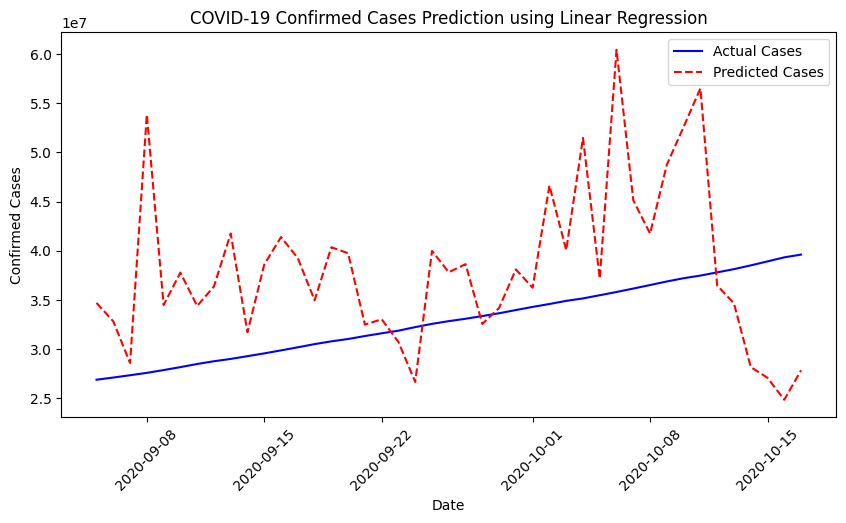

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "/content/time-series-19-covid-combined (1).csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime format and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Group by Date to get total cases per day worldwide
df_grouped = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Log transformation of 'Confirmed' cases to handle exponential growth
df_grouped['Log_Confirmed'] = np.log1p(df_grouped['Confirmed'])  # log(1 + x)

# Create multiple lag features (previous N days data)
num_lags = 7  # Consider past 7 days
for i in range(1, num_lags + 1):
    df_grouped[f'Confirmed_lag_{i}'] = df_grouped['Confirmed'].shift(i)
    df_grouped[f'Deaths_lag_{i}'] = df_grouped['Deaths'].shift(i)
    df_grouped[f'Recovered_lag_{i}'] = df_grouped['Recovered'].shift(i)

# Drop NaN values created by shifting
df_grouped.dropna(inplace=True)

# Define features and target variable
features = [f'Confirmed_lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'Deaths_lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'Recovered_lag_{i}' for i in range(1, num_lags + 1)]
target = 'Log_Confirmed'

# Splitting data into train and test sets using TimeSeriesSplit for better time-series validation
X = df_grouped[features]
y = df_grouped[target]
tscv = TimeSeriesSplit(n_splits=5)

# Initialize Linear Regression model
model = LinearRegression()

# Train and validate using time-series split
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.4f}")

# After the loop ends, we can now predict on the final test set
X_final_test = X.iloc[test_index]
y_final_test = y.iloc[test_index]
y_final_pred = model.predict(X_final_test)

# Inverse log transformation to get the actual predicted cases
y_final_pred_actual = np.expm1(y_final_pred)

# Actual confirmed cases
y_final_test_actual = np.expm1(y_final_test)

# Display predicted vs actual values for the final test set
df_results = pd.DataFrame({'Date': df_grouped['Date'].iloc[-len(y_final_test):],
                           'Actual Confirmed': y_final_test_actual,
                           'Predicted Confirmed': y_final_pred_actual})

print(df_results.head())

# Plot actual vs predicted confirmed cases
plt.figure(figsize=(10, 5))
plt.plot(df_results['Date'], df_results['Actual Confirmed'], label='Actual Cases', color='blue')
plt.plot(df_results['Date'], df_results['Predicted Confirmed'], label='Predicted Cases', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.title('COVID-19 Confirmed Cases Prediction using Linear Regression')
plt.xticks(rotation=45)
plt.show()
